# CASA0007 - Quantitative Methods Group Project
## Group 25

## Meeting Plan (05/12/2022)
- Change text back to OA data. 
- Calculate distacne from OA to central London - Joe
- Create regression model, then move to multiple regression model - Zach
- Tests the assumptions of linear regression. Scatter plots, + of risiduals to identify independence, equal varience and colinearility.  - Zach
- Clustering analysis of distance, deprivation and air quality

In [1]:
#Reading in libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import precision_score

## 1. Context of the data

### 1.0. Aggregation Level - Zach

Data is aggregated to the Output Area (OA) Level. This being the smallest level of aggregation that the census data is released on by the ONS (Office of National Statistics). 
- Each OA contains between 40 and 250 households, leading to an estimated population of between 100 and 625. 
- **Limitation** of aggregation level: OAs change between each census (10 year lifecycle) due to variation in population density, meaning data cannot always be compared between census' easily. 




**UK Administrative Units**
1. Output Areas (OAs)
2. Lower Super Output Areas (LSOAs)
3. Middle layer Super Output Areas (MSOAs)
4. Boroughs/ Local Administrative Unit (LAD)


### 1.1. Cycling to work: Census Data
This dataset is from the 2011 Census. Results are based off a Census question that classifies usual residents aged 16 to 74 in England and Wales by their method of travel to work, disaggregated by Census Output Area (OA). The estimates are as at census day, 27 March 2011 (single time snapshot). The dataset can be found [here](https://www.nomisweb.co.uk/census/2011/qs701ew).  


### 1.2. Deprivation - Yubin

The dataset is based on the 2011 Census provided by Office for National Statistics (ONS), classified households in England and Wales through four domains of deprivation: Employment, Education, Health and disability, and Household overcrowding. It is a nationally representative data and the estimates are as at census day, 27 March 2011.

A household would be defined as deprived if they meet one or more of the following conditions:

1. Employment: Any member of a household, who is not a full-time student, is either unemployed or long-term sick.
2. Education: No person in the household has at least Level 2 education (see highest level of qualification), and no person aged 16 to 18 is a full-time student.
3. Health and disability: Any person in the household has general health that is 'bad' or 'very bad' or has a long-term health problem.
4. Housing: The household's accommodation is either overcrowded, with an occupancy rating -1 or less, or is in a shared dwelling, or has no central heating.



### 1.3. Air Quality - Zach [[Data](https://data.london.gov.uk/dataset/pm2-5-map-and-exposure-data)]

This dataset identifies modelled PM<sub>2.5 </sub>(particulate matter of diameter 2.5 micrometers or less) across London's Output Areas. 
- Modelled by Tfl (Transport for London) and GLA (Greater London Authority)

Increased exposure to high levels of partculate matter have been linked to increased rate of cardiovascular and respiratory disease (Liu, 2019). 

This data is being considered due to the assumption that emission levels infulence the decision making process of commuters. This emissions data could be used as a proxy for volume of motor vehicles, or considered as a variable having an impact by itself on decision making.



| Variable| Unit | Description |
| --- | --- | --- |
| PM<sub>2.5 </sub> | µg/m<sup>3 </sup>| Modelled concentration of particulate matter with diameter or 2.5 micrometers or less. | 


**Limitations:**
- Assuming causality of air quality and commuting choice would be incorrect. It is possible that air pollution is low due to choice of pollution. Suggesting an inverse relationship to that initally proposed. 


### 1.5. Additional Predictor Variables
* Distance travelled to work
* Demographics (Age)
* Road casualties



## 2. Description of data fields/ variables

### 2.1. Cycling to work - Joe
* Read in the data

In [2]:
# cycletowork = pd.read_csv('data/oa/cycleing_to_work_oa.csv')

#MSOA data
cycletowork = pd.read_csv('data/msoa/cyclingtowork_2011census_msoa.csv')

# print(cycletowork.columns)
print(cycletowork.shape)

#Drop unnecessary columns
cycletowork = cycletowork[['date',
                           'geography code',
                           'Method of Travel to Work: Bicycle; measures: Value',
                           'Method of Travel to Work: All categories: Method of travel to work; measures: Value']]

# CLean column names
cycletowork.rename(columns = {'date':'year',
                              'geography code':'msoa_code',
                              'Method of Travel to Work: Bicycle; measures: Value':'cycling_count',
                              'Method of Travel to Work: All categories: Method of travel to work; measures: Value':'total_count'}, 
                   inplace = True)

#Calculate rate column
cycletowork['cycling_rate'] = cycletowork['cycling_count']/cycletowork['total_count']

print(cycletowork.shape)
print(cycletowork.dtypes)

(7201, 17)
(7201, 5)
year               int64
msoa_code         object
cycling_count      int64
total_count        int64
cycling_rate     float64
dtype: object


The relevant fields for our analysis are as follows:
| Original name  | Cleaned name | Data type  | Description  |
|---|---|---|---|
| Date  | year | Integer  | Year data  was collected (2011 census).  |
| Geography code  | msoa_code | String  | Census Medium Layer Super Output Area unique identifier.  |
| Method of Travel to Work: Bicycle  | cycling_count | Integer  | Count of residents aged 16 to 74 who used a bicycle as their method of travel to work on the Census date.  |
| Method of Travel to Work: All categories  | total_count | Integer  | Total count of residents aged 16 to 74 who provided a response for method of travel to work on the census date.  |
| N/A  | cycling_rate | Float (decimal)  | Count of cyclists divided by the total count of travellers to work in output area  |
   

### 2.2. Deprivation

In [3]:
deprivation = pd.read_csv("data/oa/deprivation_oa.csv")

#Clean column names
deprivation.rename(columns = {'Household Deprivation: All categories: Classification of household deprivation; measures: Value':'hhdep_all',
                          'Household Deprivation: Household is not deprived in any dimension; measures: Value':'hhdep0',
                          'Household Deprivation: Household is deprived in 1 dimension; measures: Value':'hhdep1',
                          'Household Deprivation: Household is deprived in 2 dimensions; measures: Value':'hhdep2',
                          'Household Deprivation: Household is deprived in 3 dimensions; measures: Value':'hhdep3',
                          'Household Deprivation: Household is deprived in 4 dimensions; measures: Value':'hhdep4',
                          'geography code':'oa_code'
                         }, 
                   inplace = True)

print(deprivation.shape)
deprivation.dtypes

(25053, 10)


date            int64
geography      object
oa_code        object
Rural Urban    object
hhdep_all       int64
hhdep0          int64
hhdep1          int64
hhdep2          int64
hhdep3          int64
hhdep4          int64
dtype: object

### 2.3. Air Quality - Zach

In [4]:
#Reading in data
aq_df = pd.read_csv("data/oa/OA2_PM25_2013.csv")

#Identifying usable columns
aq_df.head()

,OA11CD,LAD11NM,PM252013me
0,E00024024,Westminster,17.953073
1,E00023833,Westminster,18.183844
2,E00023830,Westminster,18.732058
3,E00023831,Westminster,17.909357
4,E00024021,Westminster,17.185809


Columns:
- OA11CD refers to the unique Output Area code, allowing merging with other data as an explanatory variable. 
- LAD11NM refers to the Borough (three levels of aggregation above OAs) that the OA is within. Boroughs are local administrative units that resources are allocatacted to, which are then distributed across the OAs dependnent on needs. 

### 2.4 Demographic

In [5]:
# Reading Data
gender = pd.read_csv('https://raw.githubusercontent.com/ZacharyP-E/qm_group25/main/data/msoa/sex_msoa.csv')
age = pd.read_csv('https://raw.githubusercontent.com/ZacharyP-E/qm_group25/main/data/msoa/age_msoa.csv')
ethics = pd.read_csv('https://raw.githubusercontent.com/ZacharyP-E/qm_group25/main/data/msoa/ethic_msoa.csv')
qualification = pd.read_csv('https://raw.githubusercontent.com/ZacharyP-E/qm_group25/main/data/msoa/qualification_msoa.csv')


In [6]:
# Merge table
demographic1 = gender.merge(age, how='left', left_on='2011 super output area - middle layer', right_on = '2011 super output area - middle layer')
demographic2 = demographic1.merge(ethics, how='left', left_on='2011 super output area - middle layer', right_on = '2011 super output area - middle layer')
demographic = demographic2.merge(qualification, how='left', left_on='2011 super output area - middle layer', right_on = '2011 super output area - middle layer')
demographic.columns

Index(['2011 super output area - middle layer', 'All persons', 'Males',
       'Females', 'All usual residents_x', '0_4', '5_7', ' 8_9', ' 10_14',
       '15', ' 16_17', ' 18_19', ' 20_24', ' 25_29', ' 30_44', '45_59',
       '60_64', '65_74', '75_84', '85_89', '90_and_over',
       'All usual residents_y', 'White', 'Mixed/multiple ethnic groups',
       'Asian/Asian British', 'Black/African/Caribbean/Black British',
       'Other ethnic group', 'All categories Highest level of qualification',
       'No qualifications'],
      dtype='object')

In [7]:
# rename columns
demographic.rename(columns = {'2011 super output area - middle layer':'msoa_code',
                          'All persons':'population',
                          'Mixed/multiple ethnic groups':'mixed',
                          'Asian/Asian British':'asian',
                          'Black/African/Caribbean/Black British':'black',
                          'Other ethnic group':'other_ethic',
                          'All categories Highest level of qualification':'total_qual',
                          'No qualifications':'no_qual'
                         }, 
                   inplace = True)

demographic.columns

Index(['msoa_code', 'population', 'Males', 'Females', 'All usual residents_x',
       '0_4', '5_7', ' 8_9', ' 10_14', '15', ' 16_17', ' 18_19', ' 20_24',
       ' 25_29', ' 30_44', '45_59', '60_64', '65_74', '75_84', '85_89',
       '90_and_over', 'All usual residents_y', 'White', 'mixed', 'asian',
       'black', 'other_ethic', 'total_qual', 'no_qual'],
      dtype='object')

In [8]:
# drop unwanted columns
demographic = demographic[['msoa_code', 'population', 'Males', 'Females','0_4', '5_7', ' 8_9', ' 10_14', '15', ' 16_17', ' 18_19', ' 20_24',
       ' 25_29', ' 30_44', '45_59', '60_64', '65_74', '75_84', '85_89',
       '90_and_over','White', 'mixed', 'asian', 'black', 'other_ethic', 'total_qual', 'no_qual']]

demographic.head(3)

,msoa_code,population,Males,Females,0_4,5_7,8_9,10_14,15,16_17,...,75_84,85_89,90_and_over,White,mixed,asian,black,other_ethic,total_qual,no_qual
0,E02000166 Camden 001,7924,3689,4235,5.7,3.2,2.1,5.2,1.2,2.1,...,4.8,1.2,0.6,79.4,6.4,5.8,5.7,2.7,6541,861
1,E02000167 Camden 002,7944,3880,4064,6.6,3.8,1.9,4.7,0.7,1.4,...,5.8,1.5,0.9,84.8,4.7,6.7,1.9,1.9,6541,361
2,E02000168 Camden 003,8172,3928,4244,6.0,3.2,2.0,4.6,1.0,1.9,...,3.7,0.8,0.6,78.2,6.6,7.2,5.7,2.4,6795,844


In [9]:
# gender proportion
demographic['male_prop'] = demographic['Males']/demographic['population']
demographic['female_prop'] = demographic['Females']/demographic['population']
demographic.columns

Index(['msoa_code', 'population', 'Males', 'Females', '0_4', '5_7', ' 8_9',
       ' 10_14', '15', ' 16_17', ' 18_19', ' 20_24', ' 25_29', ' 30_44',
       '45_59', '60_64', '65_74', '75_84', '85_89', '90_and_over', 'White',
       'mixed', 'asian', 'black', 'other_ethic', 'total_qual', 'no_qual',
       'male_prop', 'female_prop'],
      dtype='object')

In [10]:
# age proportion
demographic['under_18'] = (demographic['0_4'] + demographic['5_7'] + demographic[' 8_9'] + demographic[' 10_14'] + demographic['15'] + demographic[' 16_17'])/100
demographic['adult'] = (demographic[' 18_19'] + demographic[' 20_24'] + demographic[' 25_29'] + demographic[' 30_44'] + demographic['45_59'] + demographic['60_64'])/100
demographic['elderly'] = (demographic['65_74'] + demographic['75_84'] + demographic['85_89'] + demographic['90_and_over'] )/100
demographic.columns

Index(['msoa_code', 'population', 'Males', 'Females', '0_4', '5_7', ' 8_9',
       ' 10_14', '15', ' 16_17', ' 18_19', ' 20_24', ' 25_29', ' 30_44',
       '45_59', '60_64', '65_74', '75_84', '85_89', '90_and_over', 'White',
       'mixed', 'asian', 'black', 'other_ethic', 'total_qual', 'no_qual',
       'male_prop', 'female_prop', 'under_18', 'adult', 'elderly'],
      dtype='object')

In [11]:
# qualification proportion
demographic['qual_rate'] = demographic['no_qual']/demographic['total_qual']

In [12]:
# drop unwanted columns again
demographic = demographic[['msoa_code','White', 'mixed', 'asian', 'black', 'other_ethic', 
                           'male_prop', 'female_prop', 
                           'under_18', 'adult', 'elderly',
                           'qual_rate']]
demographic.head(5)

,msoa_code,White,mixed,asian,black,other_ethic,male_prop,female_prop,under_18,adult,elderly,qual_rate
0,E02000166 Camden 001,79.4,6.4,5.8,5.7,2.7,0.465548,0.534452,0.195,0.650,0.154,0.131631
1,E02000167 Camden 002,84.8,4.7,6.7,1.9,1.9,0.488419,0.511581,0.191,0.639,0.169,0.055190
2,E02000168 Camden 003,78.2,6.6,7.2,5.7,2.4,0.480666,0.519334,0.187,0.694,0.118,0.124209
3,E02000169 Camden 004,75.9,6.1,11.7,2.4,3.9,0.479900,0.520100,0.206,0.640,0.156,0.067173
4,E02000170 Camden 005,74.3,5.6,10.9,4.6,4.5,0.495802,0.504198,0.167,0.736,0.098,0.076403


In [13]:
# change proportion figure to decimal point

demographic['White'] = demographic['White']/100
demographic['mixed'] = demographic['mixed']/100
demographic['asian'] = demographic['asian']/100
demographic['black'] = demographic['black']/100
demographic['other_ethic'] = demographic['other_ethic']/100
demographic.head(5)

,msoa_code,White,mixed,asian,black,other_ethic,male_prop,female_prop,under_18,adult,elderly,qual_rate
0,E02000166 Camden 001,0.794,0.064,0.058,0.057,0.027,0.465548,0.534452,0.195,0.650,0.154,0.131631
1,E02000167 Camden 002,0.848,0.047,0.067,0.019,0.019,0.488419,0.511581,0.191,0.639,0.169,0.055190
2,E02000168 Camden 003,0.782,0.066,0.072,0.057,0.024,0.480666,0.519334,0.187,0.694,0.118,0.124209
3,E02000169 Camden 004,0.759,0.061,0.117,0.024,0.039,0.479900,0.520100,0.206,0.640,0.156,0.067173
4,E02000170 Camden 005,0.743,0.056,0.109,0.046,0.045,0.495802,0.504198,0.167,0.736,0.098,0.076403


In [14]:
demographic[['code', 'name']] = demographic['msoa_code'].str.split(' ', 1, expand=True)
demographic.columns

Index(['msoa_code', 'White', 'mixed', 'asian', 'black', 'other_ethic',
       'male_prop', 'female_prop', 'under_18', 'adult', 'elderly', 'qual_rate',
       'code', 'name'],
      dtype='object')

In [15]:
# drop unwanted the column 
demographic = demographic[['code', 'name','White', 'mixed', 'asian', 'black', 'other_ethic',
       'male_prop', 'female_prop', 'under_18', 'adult', 'elderly', 'qual_rate']]
demographic.head(3)

,code,name,White,mixed,asian,black,other_ethic,male_prop,female_prop,under_18,adult,elderly,qual_rate
0,E02000166,Camden 001,0.794,0.064,0.058,0.057,0.027,0.465548,0.534452,0.195,0.650,0.154,0.131631
1,E02000167,Camden 002,0.848,0.047,0.067,0.019,0.019,0.488419,0.511581,0.191,0.639,0.169,0.055190
2,E02000168,Camden 003,0.782,0.066,0.072,0.057,0.024,0.480666,0.519334,0.187,0.694,0.118,0.124209


### 2.5 Distance

In [16]:
distance = pd.read_csv("data/oa/distance_to_work_oa.csv")

In [17]:
distance = distance[["2011 output area", "Average distance (km)"]]

Columns of use:
- 2011 Output area 
    - A unique code identifier allowing merging with other datasets
- Average distacne (km) 
    - The average distance an resident would travel to work

In [18]:
distance = distance.rename(columns={"Average distance (km)":"distance"})

### 2.6 Housing Price in GBP

In [19]:
house_price = pd.read_csv('https://raw.githubusercontent.com/ZacharyP-E/qm_group25/main/data/msoa/average_house_prices_msoa.csv')
house_price.columns

Index(['Code', 'Area', 'Value'], dtype='object')

In [20]:
house_price.rename(columns = {'Code':'code','Value':'house_price'},inplace = True)
house_price.head(3)

,code,Area,house_price
0,E02000001,City of London 001,541192
1,E02000002,Barking and Dagenham 001,191618
2,E02000003,Barking and Dagenham 002,193483


### 2.7 Road Casualty

In [21]:
road_casualty = pd.read_csv('https://raw.githubusercontent.com/ZacharyP-E/qm_group25/main/data/msoa/road_casualties_severity_msoa.csv')
road_casualty.columns

Index(['MSOA Code', 'Fatal', 'Serious', 'Slight', '2011 Total'], dtype='object')

In [22]:
road_casualty.rename(columns = {'MSOA Code':'code','2011 Total':'road_casualty'},inplace = True)

In [23]:
road_casualty = road_casualty[['code','road_casualty']]
road_casualty.head(3)
road_casualty.describe()

,road_casualty
count,983.000000
mean,29.755849
std,25.841507
min,0.000000
25%,15.000000
50%,25.000000
75%,38.000000
max,405.000000


### 2.8 Car Ownership in Percentage

In [24]:
car_own = pd.read_csv('https://raw.githubusercontent.com/ZacharyP-E/qm_group25/main/data/msoa/car_ownership_msoa.csv')
car_own.columns

Index(['2011 super output area - middle layer',
       'All categories Car or van availability',
       'No cars or vans in household', '1 car or van in household',
       '2 cars or vans in household', '3 cars or vans in household',
       '4 or more cars or vans in household'],
      dtype='object')

In [25]:
car_own.rename(columns = {'2011 super output area - middle layer':'msoa_code',
                          'All categories Car or van availability':'all',
                          'No cars or vans in household':'no_car'},inplace = True)
car_own.columns

Index(['msoa_code', 'all', 'no_car', '1 car or van in household',
       '2 cars or vans in household', '3 cars or vans in household',
       '4 or more cars or vans in household'],
      dtype='object')

In [26]:
# calculate the car ownership of households
car_own = car_own[['msoa_code', 'all', 'no_car']]
car_own['car_ownership'] = (car_own['all']- car_own['no_car'])/100
car_own.columns

Index(['msoa_code', 'all', 'no_car', 'car_ownership'], dtype='object')

In [27]:
#split the msoa_code
car_own[['code', 'name']] = car_own['msoa_code'].str.split(' ', 1, expand=True)
car_own.head(3)

,msoa_code,all,no_car,car_ownership,code,name
0,E02000166 Camden 001,100,48.2,0.518,E02000166,Camden 001
1,E02000167 Camden 002,100,41.3,0.587,E02000167,Camden 002
2,E02000168 Camden 003,100,55.5,0.445,E02000168,Camden 003


In [28]:
# drop unwanted the column 
car_own = car_own[['code','car_ownership']]
car_own.head(3)

,code,car_ownership
0,E02000166,0.518
1,E02000167,0.587
2,E02000168,0.445


### 2.9 Housing Ownership in Percentage

In [29]:
house_own = pd.read_csv('https://raw.githubusercontent.com/ZacharyP-E/qm_group25/main/data/msoa/tenure_msoa.csv')
house_own.columns

Index(['2011 super output area - middle layer', 'All households', 'Owned',
       'Shared ownership (part owned and part rented)', 'Social rented',
       'Private rented', 'Living rent free'],
      dtype='object')

In [30]:
house_own.rename(columns = {'2011 super output area - middle layer':'msoa_code',
                            'Shared ownership (part owned and part rented)':'share_owned'},inplace = True)
house_own.columns

Index(['msoa_code', 'All households', 'Owned', 'share_owned', 'Social rented',
       'Private rented', 'Living rent free'],
      dtype='object')

In [31]:
# calculate the house ownership of households
house_own['house_ownership'] = (house_own['Owned']- house_own['share_owned'])/100

In [32]:
#split the msoa_code
house_own[['code', 'name']] = house_own['msoa_code'].str.split(' ', 1, expand=True)
house_own.head(3)

,msoa_code,All households,Owned,share_owned,Social rented,Private rented,Living rent free,house_ownership,code,name
0,E02000166 Camden 001,100,45.1,0.8,36.0,16.1,2.0,0.443,E02000166,Camden 001
1,E02000167 Camden 002,100,55.6,0.2,8.4,33.4,2.5,0.554,E02000167,Camden 002
2,E02000168 Camden 003,100,42.0,0.8,29.3,26.7,1.3,0.412,E02000168,Camden 003


In [33]:
# # drop unwanted the column 
house_own = house_own[['code', 'house_ownership']]
house_own.head(3)

,code,house_ownership
0,E02000166,0.443
1,E02000167,0.554
2,E02000168,0.412


## 3. Summary statistic fields

### 3.1. Cycling to work - Joe

In [34]:
cycletowork.describe()

,year,cycling_count,total_count,cycling_rate
count,7201.0,7201.000000,7201.000000,7201.000000
mean,2011.0,105.865019,5711.226219,0.017934
std,0.0,120.777752,1243.733145,0.017921
min,2011.0,2.000000,1622.000000,0.000391
25%,2011.0,41.000000,4766.000000,0.007551
50%,2011.0,68.000000,5539.000000,0.012391
75%,2011.0,126.000000,6407.000000,0.021843
max,2011.0,1824.000000,15222.000000,0.246464


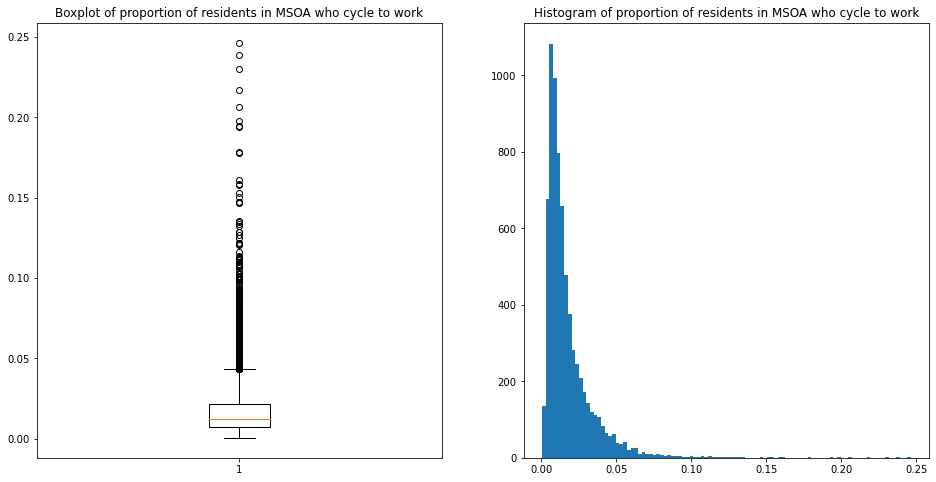

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.boxplot(cycletowork.cycling_rate,
           vert = True)
ax1.set_title("Boxplot of proportion of residents in MSOA who cycle to work")
ax2.hist(cycletowork.cycling_rate,
        bins = 100)
ax2.set_title("Histogram of proportion of residents in MSOA who cycle to work")
plt.show()

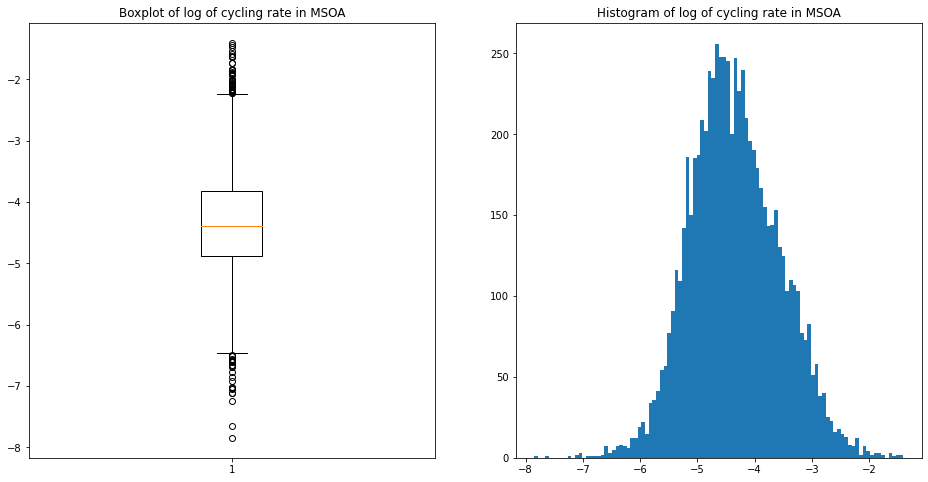

In [36]:
#Try normalising the cycling data?
#Applying a log function to the data
cycletowork["log_cyclingrate"] = np.log(cycletowork["cycling_rate"])

#Recreate plots with log values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.boxplot(cycletowork.log_cyclingrate,
           vert = True)
ax1.set_title("Boxplot of log of cycling rate in MSOA")
ax2.hist(cycletowork.log_cyclingrate,
        bins = 100)
ax2.set_title("Histogram of log of cycling rate in MSOA")
plt.show()

### 3.2. Deprivation

In [37]:
deprivation.describe()

,date,hhdep_all,hhdep0,hhdep1,hhdep2,hhdep3,hhdep4
count,25053.0,25053.000000,25053.000000,25053.000000,25053.000000,25053.000000,25053.000000
mean,2011.0,130.370534,51.389375,44.623877,25.020596,8.156508,1.180178
std,0.0,26.055859,20.982224,13.801825,11.864124,6.439494,1.637989
min,2011.0,40.000000,1.000000,6.000000,0.000000,0.000000,0.000000
25%,2011.0,116.000000,35.000000,36.000000,16.000000,3.000000,0.000000
50%,2011.0,127.000000,50.000000,43.000000,24.000000,7.000000,1.000000
75%,2011.0,140.000000,66.000000,51.000000,33.000000,12.000000,2.000000
max,2011.0,471.000000,201.000000,294.000000,111.000000,71.000000,30.000000


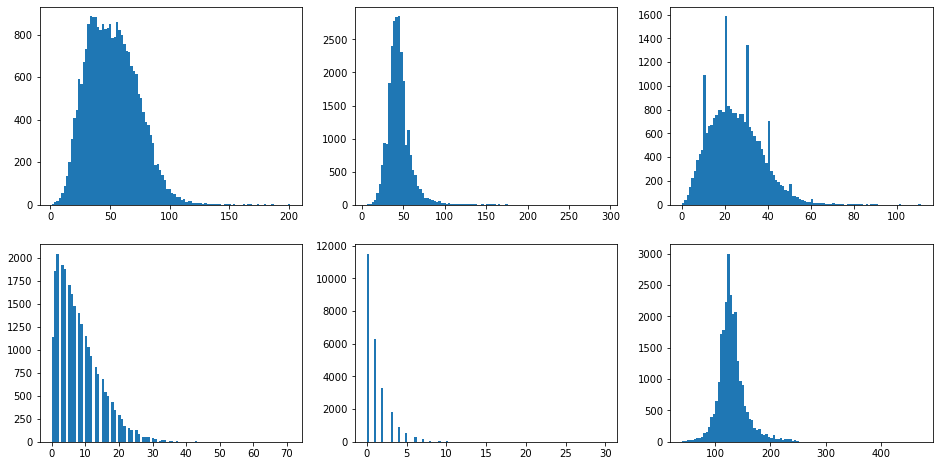

In [38]:
# Distribution plots for household deprivation measures
fig, axs = plt.subplots(2, 3, figsize=(16,8))

#Could probably do this in a loop somehow...
axs[0,0].hist(deprivation.hhdep0,
        bins = 100)
axs[0,1].hist(deprivation.hhdep1,
        bins = 100)
axs[0,2].hist(deprivation.hhdep2,
        bins = 100)
axs[1,0].hist(deprivation.hhdep3,
        bins = 100)
axs[1,1].hist(deprivation.hhdep4,
        bins = 100)
axs[1,2].hist(deprivation.hhdep_all,
        bins = 100)

plt.show()

Some weird distributions once you get to 3&4 deprived measures... not sure how best to handle this?

### 3.3. Air Quality - Zach

In [39]:
aq_df.describe()

,PM252013me
count,25946.000000
mean,16.001274
std,0.788874
min,14.283266
25%,15.417784
50%,15.873302
75%,16.464573
max,21.100099


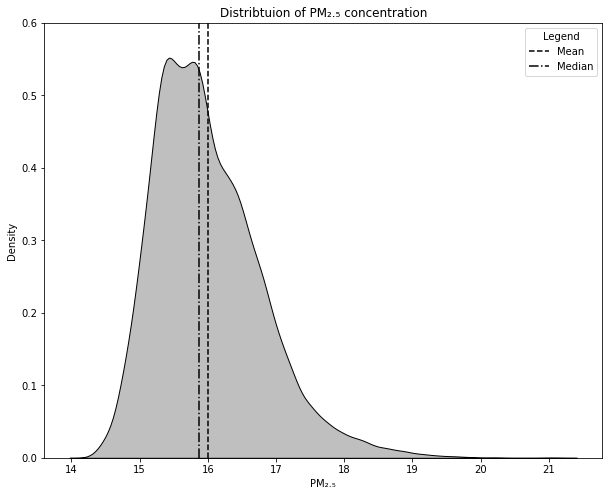

In [40]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.kdeplot(aq_df["PM252013me"], ax=ax, color="black", shade=True)
plt.xlabel("PM\u2082.\u2085")
plt.vlines(aq_df["PM252013me"].mean(), 0, 0.65, linestyle="--", color="black", label="Mean")
plt.vlines(aq_df["PM252013me"].median(), 0, 0.65, linestyle="-.", color="black", label="Median")
plt.legend(title="Legend")
plt.title("Distribtuion of PM\u2082.\u2085 concentration")
plt.ylim(0,0.60)
plt.savefig("figures/aq_kdeplot.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

Data appears to be positvely skewed. Would applying a log fix it?

In [41]:
aq_df["dif_mean"] = aq_df["PM252013me"] - aq_df["PM252013me"].mean()

In [42]:
aq_df["dif_mean_and_std"] = aq_df["dif_mean"] / aq_df["PM252013me"].std()

In [43]:
#Applying a log function to the data
aq_df["PMlog"] = np.log(aq_df["PM252013me"])

None of which normalise the data

### 3.4. Road casualties

In [44]:
road_casualty.describe()

,road_casualty
count,983.000000
mean,29.755849
std,25.841507
min,0.000000
25%,15.000000
50%,25.000000
75%,38.000000
max,405.000000


In [45]:
#Applying a log function to the data
road_casualty["log_casualties"] = np.log(road_casualty["road_casualty"]+1)  # Add +1 to deal with 'zero' rows in raw data

road_casualty.describe()

,road_casualty,log_casualties
count,983.000000,983.000000
mean,29.755849,3.201026
std,25.841507,0.677797
min,0.000000,0.000000
25%,15.000000,2.772589
50%,25.000000,3.258097
75%,38.000000,3.663562
max,405.000000,6.006353


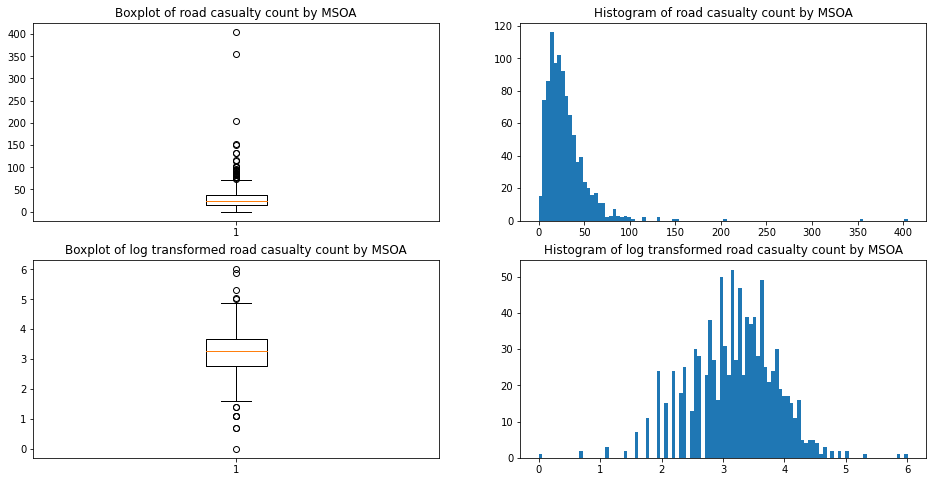

In [46]:
#Plot distribution
fig, axs = plt.subplots(2, 2, figsize=(16,8))

axs[0,0].boxplot(road_casualty.road_casualty,
           vert = True)
axs[0,0].set_title("Boxplot of road casualty count by MSOA")

axs[0,1].hist(road_casualty.road_casualty,
        bins = 100)
axs[0,1].set_title("Histogram of road casualty count by MSOA")

axs[1,0].boxplot(road_casualty.log_casualties,
           vert = True)
axs[1,0].set_title("Boxplot of log transformed road casualty count by MSOA")

axs[1,1].hist(road_casualty.log_casualties,
        bins = 100)
axs[1,1].set_title("Histogram of log transformed road casualty count by MSOA")

plt.show()


## 4. Appropriate plots to communicate distribution

### 4.0. Merging of data

In [47]:
#Import correspondence file
oa_to_msoa = pd.read_csv("data/msoa/oa_to_msoa_correspondence.csv")
# oa_to_msoa.dtypes

In [48]:
#Merge deprivation dataset to OA/MSOA correspondence file
dep_msoa = deprivation.merge(oa_to_msoa, how='left', left_on='oa_code', right_on='OA11CD')
dep_msoa.shape

(25053, 27)

In [49]:
#Summarise deprivation statistics by MSOA
dep_sum = dep_msoa.groupby(['MSOA11CD', 'MSOA11NM']).agg(
    {
       'hhdep_all':sum,
       'hhdep0':sum,
       'hhdep1':sum,
       'hhdep2':sum,
       'hhdep3':sum,
       'hhdep4':sum,
    }
)


#Add proportion caclulated columns (rate of deprived households amongst total household count)
dep_sum['hhdep0_rate'] = dep_sum['hhdep0']/dep_sum['hhdep_all']
dep_sum['hhdep1_rate'] = dep_sum['hhdep1']/dep_sum['hhdep_all']
dep_sum['hhdep2_rate'] = dep_sum['hhdep2']/dep_sum['hhdep_all']
dep_sum['hhdep3_rate'] = dep_sum['hhdep3']/dep_sum['hhdep_all']
dep_sum['hhdep4_rate'] = dep_sum['hhdep4']/dep_sum['hhdep_all']

dep_sum = dep_sum.reset_index(level=[0,1])

dep_sum.shape

(983, 13)

In [50]:
#Merge air quality datset to OA/MSOA correspondence file
aq_msoa = aq_df.merge(oa_to_msoa, how='left', on='OA11CD')
aq_msoa.shape

(25946, 22)

In [51]:
#Summarise air quality statistics by MSOA
aq_sum = aq_msoa.groupby(['MSOA11CD', 'MSOA11NM'])['PM252013me'].mean()
aq_sum = aq_sum.reset_index(level=[0,1])
aq_sum.shape

(983, 3)

In [52]:
#Summarise distance to work by MSOA
distance_msoa = distance.merge(oa_to_msoa, how="left", left_on = "2011 output area", right_on="OA11CD").groupby('MSOA11CD')['distance'].mean().reset_index()

* Merge the three datasets together by MSOA Code

In [53]:
# Comment out this cell to use MSOA cycling data loaded above

# cycletowork = pd.read_csv("data/oa/cycleing_to_work_oa.csv")

#Merging the cycle to work data to deprivation data to form a main dataframe
# df = cycletowork.merge(deprivation, how="left", on="geography code")

In [54]:
# Add the cycling dataset to the deprivation
df = dep_sum.merge(cycletowork, how = "left", left_on="MSOA11CD", right_on="msoa_code")

In [55]:
#Adding the air quality data to the main dataframe
df = df.merge(aq_sum, how = "left", on="MSOA11CD")

In [56]:
df = df.merge(distance_msoa, how="left", on = "MSOA11CD")

In [57]:
df.shape

(983, 22)

In [58]:
#Identifying any NA values
df.isna().sum().reset_index().rename(columns={"index":"Column Name", 0:"Quantity of NAs"})

,Column Name,Quantity of NAs
0,MSOA11CD,0
1,MSOA11NM_x,0
2,hhdep_all,0
3,hhdep0,0
4,hhdep1,0
5,hhdep2,0
6,hhdep3,0
7,hhdep4,0
8,hhdep0_rate,0
9,hhdep1_rate,0


No NA values present within the dataset

In [59]:
#Removing any duplicated rows.
df = df.drop_duplicates(keep="first")

In [60]:
df.head(3)

,MSOA11CD,MSOA11NM_x,hhdep_all,hhdep0,hhdep1,hhdep2,hhdep3,hhdep4,hhdep0_rate,hhdep1_rate,...,hhdep4_rate,year,msoa_code,cycling_count,total_count,cycling_rate,log_cyclingrate,MSOA11NM_y,PM252013me,distance
0,E02000001,City of London 001,4385,1973,1772,499,122,19,0.449943,0.404105,...,0.004333,2011,E02000001,252,6307,0.039956,-3.219986,City of London 001,18.191034,6.958065
1,E02000002,Barking and Dagenham 001,2713,734,916,824,217,22,0.270549,0.337634,...,0.008109,2011,E02000002,34,4360,0.007798,-4.853867,Barking and Dagenham 001,15.233410,14.595455
2,E02000003,Barking and Dagenham 002,3834,1335,1352,887,236,24,0.348200,0.352634,...,0.006260,2011,E02000003,42,7149,0.005875,-5.137058,Barking and Dagenham 002,15.370681,13.853333


### 4.0.1 Demographic data

In [61]:
new = demographic.merge(house_price, how = "left", left_on="code", right_on="code")
new1 = new.merge(road_casualty, how = "left", left_on="code", right_on="code")
new2 = new1.merge(car_own, how = "left", left_on="code", right_on="code")
new3 = new2.merge(house_own, how = "left", left_on="code", right_on="code")

In [62]:
dataframe = new3.merge(df, how = "left", left_on="code", right_on="msoa_code")
dataframe.head(3)

,code,name,White,mixed,asian,black,other_ethic,male_prop,female_prop,under_18,...,hhdep4_rate,year,msoa_code,cycling_count,total_count,cycling_rate,log_cyclingrate,MSOA11NM_y,PM252013me,distance
0,E02000166,Camden 001,0.794,0.064,0.058,0.057,0.027,0.465548,0.534452,0.195,...,0.010178,2011,E02000166,417,6020,0.069269,-2.669756,Camden 001,16.129558,9.239286
1,E02000167,Camden 002,0.848,0.047,0.067,0.019,0.019,0.488419,0.511581,0.191,...,0.003307,2011,E02000167,201,5885,0.034155,-3.376857,Camden 002,16.219346,9.863333
2,E02000168,Camden 003,0.782,0.066,0.072,0.057,0.024,0.480666,0.519334,0.187,...,0.012447,2011,E02000168,543,6371,0.085230,-2.462402,Camden 003,16.521069,8.071429


In [63]:
dataframe.columns

Index(['code', 'name', 'White', 'mixed', 'asian', 'black', 'other_ethic',
       'male_prop', 'female_prop', 'under_18', 'adult', 'elderly', 'qual_rate',
       'Area', 'house_price', 'road_casualty', 'log_casualties',
       'car_ownership', 'house_ownership', 'MSOA11CD', 'MSOA11NM_x',
       'hhdep_all', 'hhdep0', 'hhdep1', 'hhdep2', 'hhdep3', 'hhdep4',
       'hhdep0_rate', 'hhdep1_rate', 'hhdep2_rate', 'hhdep3_rate',
       'hhdep4_rate', 'year', 'msoa_code', 'cycling_count', 'total_count',
       'cycling_rate', 'log_cyclingrate', 'MSOA11NM_y', 'PM252013me',
       'distance'],
      dtype='object')

In [88]:
dataframe_corr = dataframe[['cycling_rate', 'log_cyclingrate',
                            'White', 'mixed', 'asian', 'black', 'other_ethic',
                            'male_prop', 'female_prop', 
                            'under_18', 'adult', 'elderly', 'qual_rate',
                            'house_price', 'road_casualty', 'log_casualties',
                            'car_ownership','house_ownership', 
                            'hhdep0_rate', 'hhdep1_rate','hhdep2_rate', 'hhdep3_rate', 'hhdep4_rate',
                            'PM252013me', "distance"]]        

In [89]:
#Updated dataframe considering variables that dont explain eachother. 
dataframe_corr = dataframe_corr[['cycling_rate', 'log_cyclingrate', #Cycle rate stayes as we are trying to explain it
                            'White', #With population of white residents we can calculate % ethnic minotirty. 
                            'male_prop', #With male we can calcualte female. 
                            'under_18', 'adult', 'elderly', 
                                 'qual_rate',
                            'house_price', 
                                 'road_casualty', 
                                 'log_casualties', #Transformed for normalised distribution
                            'car_ownership',
                                 'house_ownership', 
                             'hhdep1_rate', #Only one deprivation marker nescessary, as they all link. 
                            'PM252013me', #Pollution as an explanatory variables
                                 "distance"]]        

## 4.0.0 Correlation test

In [66]:
#print(dataframe_corr.corr())

Text(0.5, 1.0, 'Correlation Matrix')

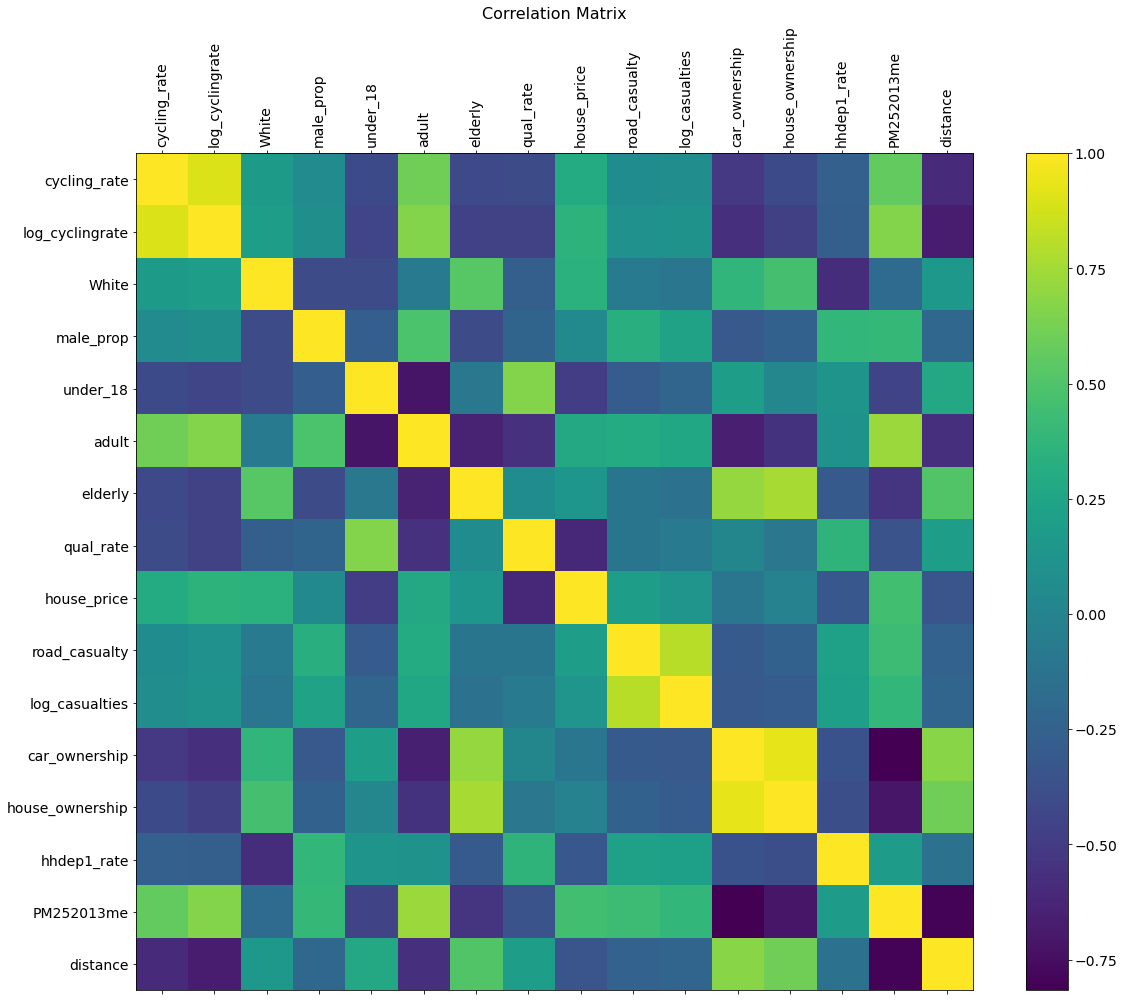

In [90]:
f = plt.figure(figsize=(19, 15))
plt.matshow(dataframe_corr.corr(), fignum=f.number)
plt.xticks(range(dataframe_corr.shape[1]), dataframe_corr.columns, fontsize=14, rotation=90)
plt.yticks(range(dataframe_corr.shape[1]), dataframe_corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [68]:
dataframe_corr

,cycling_rate,log_cyclingrate,White,male_prop,under_18,adult,elderly,qual_rate,house_price,road_casualty,car_ownership,house_ownership,hhdep1_rate,PM252013me,distance
0,0.069269,-2.669756,0.794,0.465548,0.195,0.650,0.154,0.131631,841537,16,0.518,0.443,0.304778,16.129558,9.239286
1,0.034155,-3.376857,0.848,0.488419,0.191,0.639,0.169,0.055190,1514342,10,0.587,0.554,0.315514,16.219346,9.863333
2,0.085230,-2.462402,0.782,0.480666,0.187,0.694,0.118,0.124209,554520,38,0.445,0.412,0.335219,16.521069,8.071429
3,0.023272,-3.760484,0.759,0.479900,0.206,0.640,0.156,0.067173,1440181,10,0.676,0.552,0.296397,16.258028,10.860000
4,0.037789,-3.275738,0.743,0.495802,0.167,0.736,0.098,0.076403,654160,20,0.506,0.439,0.347897,16.237145,10.388462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.018597,-3.984766,0.481,0.517971,0.210,0.720,0.069,0.167502,244701,30,0.498,0.359,0.342708,16.143117,11.800000
979,0.019570,-3.933743,0.442,0.509272,0.196,0.725,0.077,0.168725,223544,16,0.504,0.453,0.370543,16.278088,11.387500
980,0.015621,-4.159157,0.363,0.504906,0.223,0.705,0.070,0.187929,192944,44,0.465,0.316,0.393419,16.260208,10.800000
981,0.015995,-4.135472,0.401,0.501863,0.248,0.683,0.069,0.200423,220989,17,0.445,0.268,0.363086,16.162611,11.260000


In [69]:
"""
R2 value


Distance Alone: 0.358
Adult: 0.368
PM: 0.317
Road casualties: 0.004
House ownership: 0.167
Deprivation 1 index: 0.067
Distance with PM: 0.378
Distance with Adult" 0.459
Distance with adult and PM: 0.461
Distance with qual rate: 0.441
Distance with car ownership: 0.380
Distance with houseownership: 0.362
Distance, house owenership, adult and pm: 0.462
Distance and deprivation: 0.479
Distance, deprivation, adult: 0.591
Distance, adult, deprivation, road casuality: 0.598


"""

'\nR2 value\n\n\nDistance Alone: 0.358\nAdult: 0.368\nPM: 0.317\nRoad casualties: 0.004\nHouse ownership: 0.167\nDeprivation 1 index: 0.067\nDistance with PM: 0.378\nDistance with Adult" 0.459\nDistance with adult and PM: 0.461\nDistance with qual rate: 0.441\nDistance with car ownership: 0.380\nDistance with houseownership: 0.362\nDistance, house owenership, adult and pm: 0.462\nDistance and deprivation: 0.479\nDistance, deprivation, adult: 0.591\nDistance, adult, deprivation, road casuality: 0.598\n\n\n'

### Regression Model

In [94]:
# model_cnt_aq_dep = ols('cycling_rate ~  road_casualty + distance + adult + hhdep1_rate', dataframe_corr).fit()

#Re-run model with log-transformed road casualties 
model_cnt_aq_dep = ols('cycling_rate ~  log_casualties + distance + adult + hhdep1_rate', dataframe_corr).fit()

model_cnt_aq_dep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cycling_rate   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     350.4
Date:                Sun, 11 Dec 2022   Prob (F-statistic):          1.19e-185
Time:                        11:47:50   Log-Likelihood:                 2671.4
No. Observations:                 961   AIC:                            -5333.
Df Residuals:                     956   BIC:                            -5308.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0612      0.010      5.882      0.000       0.041       0.082
log_casualties    -0.0021      0.001     -2.839      0.005      -0.004      -0.001
distance          -0.0048      0.000    -16.801      0.000      -0.005      -0.004
adult              0.1689      0.010     16.550      0.000       0.149       0.189
hhdep1_rate       -0.2554      0.015    -16.839      0.000      -0.285      -0.226
==============================================================================
Omnibus:                      468.803   Durbin-Watson:                   0.753
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3872.383
Skew:                           2.063   Prob(JB):                         0.00
Kurtosis:                      11.927   Cond. No.                         410.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Testing assumptions for multi regression model
Need to check the following assumptions of regression:
1. Linear relationship between predictors and outcome
2. Independence of errors
3. Normally distributed errors
4. Equal variance of errors

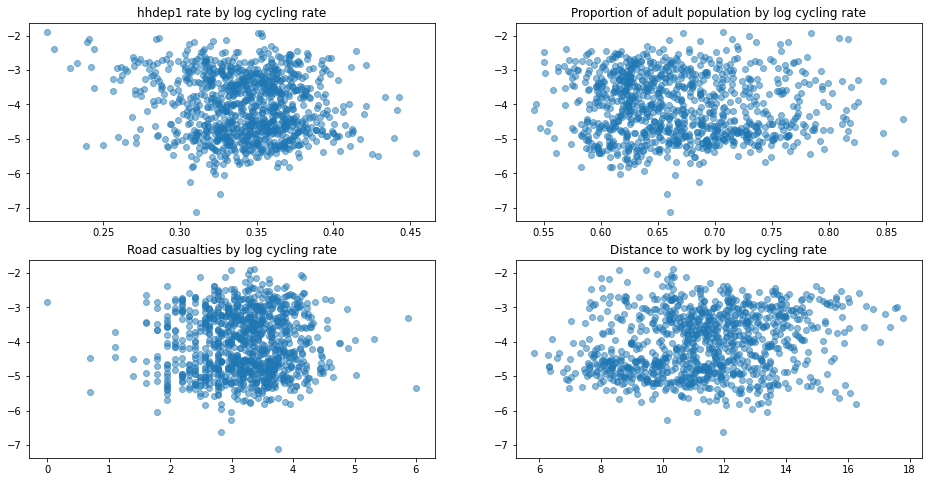

In [95]:
#If each of the variables follow a normal distribution, then assumption 1 should be met

#Scatterplot of log cycling rate (outcome) by each of the predictor variables (deprivation, distance, propn. of adults, road casualties)
fig, axs = plt.subplots(2, 2, figsize=(16,8))

axs[0,0].scatter(x=dataframe_corr['hhdep1_rate'], 
            y=df['log_cyclingrate'],
            alpha = 0.5)
axs[0,0].set_title("hhdep1 rate by log cycling rate")

axs[0,1].scatter(x=dataframe_corr['adult'], 
            y=df['log_cyclingrate'],
            alpha = 0.5)
axs[0,1].set_title("Proportion of adult population by log cycling rate")

axs[1,0].scatter(x=dataframe_corr['log_casualties'], 
            y=df['log_cyclingrate'],
            alpha = 0.5)
axs[1,0].set_title("Road casualties by log cycling rate")

axs[1,1].scatter(x=dataframe_corr['distance'], 
            y=df['log_cyclingrate'],
            alpha = 0.5)
axs[1,1].set_title("Distance to work by log cycling rate")

plt.show()


In [71]:
model_cnt_aq_dep = ols('cycling_rate ~ distance + adult + PM252013me', dataframe_corr).fit()
model_cnt_aq_dep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           cycling_rate   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     273.1
Date:                Sun, 11 Dec 2022   Prob (F-statistic):          4.81e-128
Time:                        11:27:04   Log-Likelihood:                 2534.9
No. Observations:                 961   AIC:                            -5062.
Df Residuals:                     957   BIC:                            -5042.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0120      0.025      0.472      0.637      -0.038       0.062
distance      -0.0047      0.000    -10.600      0.000      -0.006      -0.004
adult          0.1747      0.014     12.586      0.000       0.147       0.202
PM252013me    -0.0031      0.002     -1.991      0.047      -0.006   -4.51e-05
==============================================================================
Omnibus:                      347.254   Durbin-Watson:                   0.710
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1592.968
Skew:                           1.629   Prob(JB):                         0.00
Kurtosis:                       8.401   Cond. No.                         895.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='cycling_rate', ylabel='distance'>

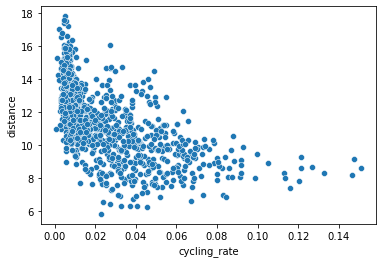

In [72]:
sns.scatterplot(data = dataframe_corr, x="cycling_rate", y="distance")


### 4.1. Basic Plotting

Check the distribution for *rate of household deprivation* measures (as probably more appropriate to use than counts?)

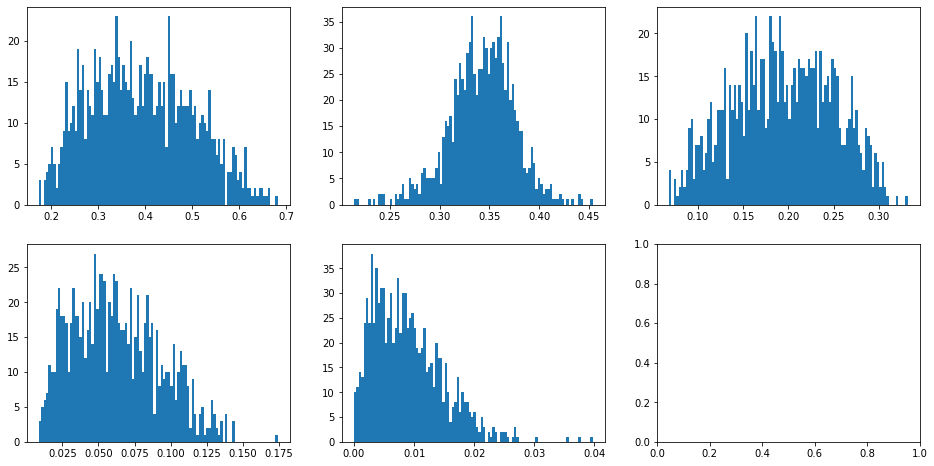

In [73]:
# Distribution plots for household deprivation RATES
fig, axs = plt.subplots(2, 3, figsize=(16,8))

axs[0,0].hist(df.hhdep0_rate,
        bins = 100)
axs[0,1].hist(df.hhdep1_rate,
        bins = 100)
axs[0,2].hist(df.hhdep2_rate,
        bins = 100)
axs[1,0].hist(df.hhdep3_rate,
        bins = 100)
axs[1,1].hist(df.hhdep4_rate,
        bins = 100)

plt.show()

#### 4.1.1 Cycle to work and Deprivation

Plot below the relationship between cycling rates (log and raw) and deprived household 4 dimensions (count and rate).  
Could also be worth looking at associations for different levels of household deprivation? (e.g. 1 or 2 dimensions)

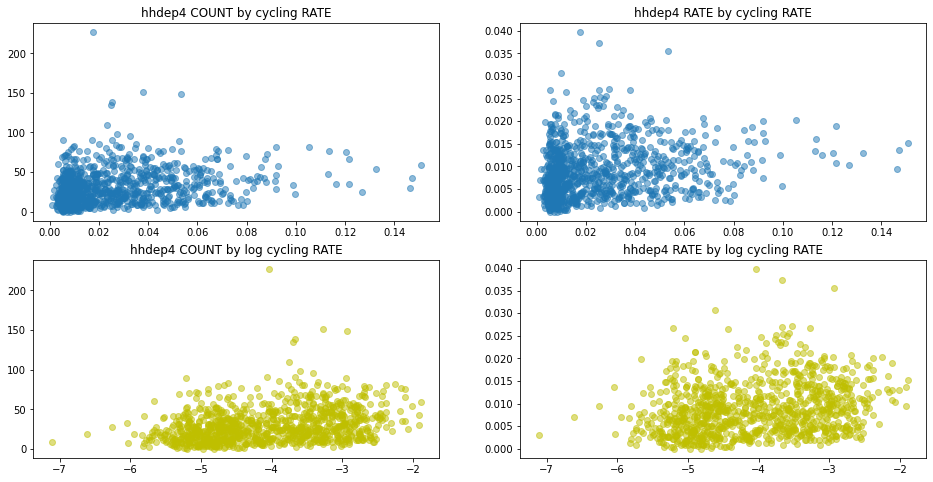

In [83]:
#Scatterplot of cycling rate and log cycling rate by deprived household rate
fig, axs = plt.subplots(2, 2, figsize=(16,8))

axs[0,0].scatter(x=df['cycling_rate'], 
            y=df['hhdep4'],
            alpha = 0.5)
axs[0,0].set_title("hhdep4 COUNT by cycling RATE")

axs[0,1].scatter(x=df['cycling_rate'], 
            y=df['hhdep4_rate'],
            alpha = 0.5)
axs[0,1].set_title("hhdep4 RATE by cycling RATE")

axs[1,0].scatter(x=df['log_cyclingrate'], 
            y=df['hhdep4'],
            c='y', alpha = 0.5)
axs[1,0].set_title("hhdep4 COUNT by log cycling RATE")

axs[1,1].scatter(x=df['log_cyclingrate'], 
            y=df['hhdep4_rate'],
            c='y', alpha = 0.5)
axs[1,1].set_title("hhdep4 RATE by log cycling RATE")

plt.show()

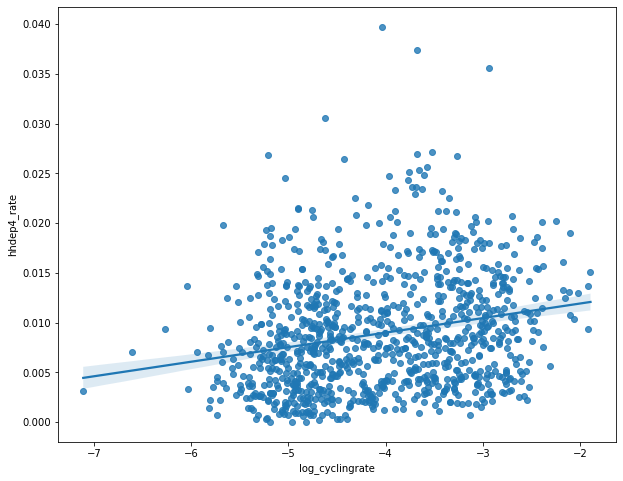

In [75]:
fig, ax = plt.subplots(1, figsize = (10,8))
sns.regplot(data = df, x="log_cyclingrate", 
            y="hhdep4_rate", ax=ax)
                       
plt.show()

#### 4.1.2 Cycle to work and Pollution

In [76]:
#Commented out cells below; rates calculated above

In [77]:
#Cycle to work proportion
# df["ctw_prop"]  = df["Method of Travel to Work: Bicycle; measures: Value"] / df["Method of Travel to Work: All categories: Method of travel to work; measures: Value"] 

In [78]:
#Deprivation on 4 dimensions proportion
# df["dep4_prop"]  = df["Household Deprivation: Household is deprived in 4 dimensions; measures: Value"] / df["Method of Travel to Work: All categories: Method of travel to work; measures: Value"] 

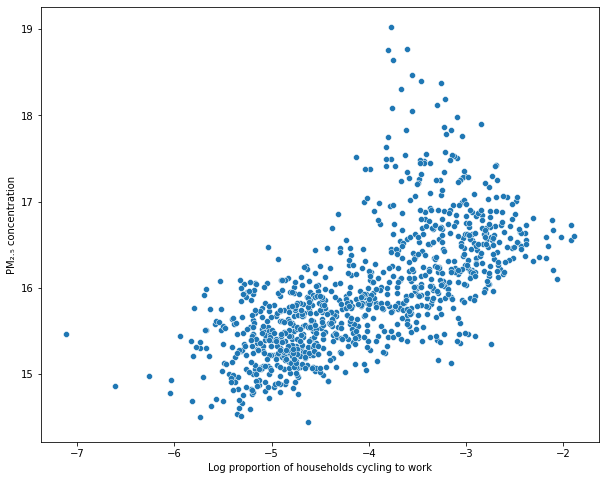

In [79]:
fig, ax = plt.subplots(1, figsize = (10,8))
sns.scatterplot(data = df, x="log_cyclingrate", 
            y="PM252013me", ax=ax)

plt.ylabel("PM\u2082.\u2085 concentration")
plt.xlabel("Log proportion of households cycling to work")
plt.show()

#### 4.1.3 Cycling to Deprivation

ValueError: Could not interpret value `ctw_prop` for parameter `x`

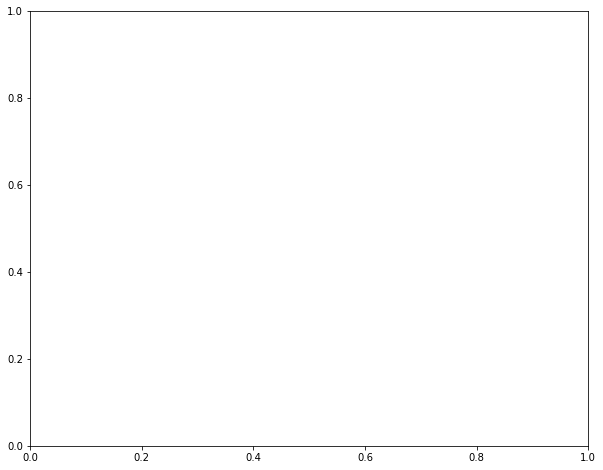

In [80]:
fig, ax = plt.subplots(1, figsize = (10,8))
sns.scatterplot(data = df, x="ctw_prop", 
            y="dep4_prop", ax=ax)
                       
plt.show()

In [ ]:
df1 = df[["OA11CD", "LAD11NM", "PM252013me", "ctw_prop", "dep4_prop"]]

In [ ]:
df2 = df[["PM252013me", "ctw_prop", "dep4_prop"]]

Testing correlation

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df2.corr(), fignum=f.number)
plt.xticks(range(df2.shape[1]), df2.columns, fontsize=14, rotation=90)
plt.yticks(range(df2.shape[1]), df2.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

No correlation present/ found

In [ ]:
model_cnt_aq_dep = ols('ctw_prop ~ PM252013me + dep4_prop', df1).fit()
model_cnt_aq_dep.summary()

In [ ]:
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(model_cnt_aq_dep, 'PM252013me', fig=fig)

### Train test split

In [ ]:
x_train, x_test,y_train,y_test = train_test_split(df1["ctw_prop"],df1["PM252013me"],test_size =0.2)

In [ ]:
#clf.predict(np.array(x_test).reshape(1,-1))

In [ ]:
olsmod = sm.OLS(y_train, x_train)
olsres = olsmod.fit()
print(olsres.summary())

In [ ]:
ypred = olsres.predict(x_test)

In [ ]:
sns.scatterplot(x=y_test, y = ypred)

In [ ]:
type(y_test)

In [ ]:
y_test = np.array(y_test).reshape(1,-1)
ypred = np.array(ypred).reshape(1,-1)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, ypred)

In [ ]:
model_cnt_aq_dep = ols('ctw_prop ~ PM252013me', df1).fit()
model_cnt_aq_dep.summary()

# 4.2. Appropriate plots to illustrate relationship between key fields

# References

Liu, C., Chen, R., Sera, F., Vicedo-Cabrera, A.M., Guo, Y., Tong, S., Coelho, M.S., Saldiva, P.H., Lavigne, E., Matus, P. and Valdes Ortega, N., 2019. Ambient particulate air pollution and daily mortality in 652 cities. New England Journal of Medicine, 381(8), pp.705-715.